# Sequential Neuron Network 

### features: ( 2010/12-2011/09/01) 

1. 'monetary_DNN':The sum of all orders' monetary values per customer during the features period.


2. 'frequency_DNN':The number of orders placed by a customer during the features period.


3. 'recency':The time between the first and last orders that were placed by a customer during the features period.


4. 't': The time between the first order placed by a customer and the end of the features period.


5. 'time_between':The average time between orders for a customer during the features period.


6. 'avg_basket_value':The average monetary value of the customer's basket during the features period.


7. 'avg_basket_size':The number of items that the customer has on average in their basket during the features period.


8. 'cnt_returns': The number of orders that the customer has returned during the features period.


9. 'has_returned': Whether the customer has returned at least one order during the features period.

### target: (2011/09/01-2011/12)

1. 'target_monetary': The total amount spent by a customer, including the training and target periods.



# Content and result 

1. Define a log for monitoring training using TensorBoard


2. Prepare features and target (train/valid/test set, StandardScaler)


3. Define a sequantial NN model for fine-tuning using Keras Tuner (RandomSearch):


       2 layers (pre-optimised)
   
       learning rate
   
       number of units for each layer
   
       activiation function
   
       initializer
   
       batch size (keras wrapper + sklearn Randomizedsearch)
   
   
4. Train a model (BN + regularizer + dropout + earstopping + Adam)

   metrics : root mean squared error = 1908
   
   
5. Monitor training using TensorBoard


6. Evaluate performence for different type of customers


        Model works best for 'Sleep/Churn' customers, worst for 'New' customers, but still pretty equal over different customers, which is very different with the bytd probabilistic model. Therefore, one could potential improve performance by combining the NN model and the btyd model.
        
7. What's the feature importance? -- SHAP VALUE

   
       monetary_DNN > has_returned > recency(negative direction)> frequency_DNN >avg_basket_value > t > avg_basket_size  > time_between  > cnt_returns  
       
    
        


In [1]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras

df_ft = pd.read_csv('features_n_target.csv')


In [230]:
features = [
 'monetary_DNN',
 'frequency_DNN',
 'recency',
 't',
 'time_between',
 'avg_basket_value',
 'avg_basket_size',
 'cnt_returns',
 'has_returned']
numeric_f = ['monetary_DNN','frequency_DNN','recency','t',
              'time_between','avg_basket_value','avg_basket_size','cnt_returns']
cate_f = ['has_returned']

target = ['target_monetary']

### Define a log for monitoring training 

In [5]:
import os
root_logdir = os.path.join(os.curdir, "my_logs——dnn")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

tensorboard = keras.callbacks.TensorBoard(run_logdir)

2021-07-23 15:09:35.378280: I tensorflow/python/profiler/internal/profiler_wrapper.cc:182] Profiling will start immediately because delay_ms was unset or zero.
2021-07-23 15:09:35.378310: I tensorflow/core/profiler/lib/profiler_session.cc:133] Profiler session started.


### Prepare features and target

In [187]:
np.random.seed(42)
# tf.random.set_seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train_full,x_test,y_train_full,y_test = train_test_split(df_ft[features],df_ft[target],test_size=0.2,random_state = 42)
X_train,X_valid,y_train,y_valid = train_test_split(x_train_full,y_train_full,test_size = 0.15, random_state = 42)

scaler = StandardScaler()
# X_train_full = scaler.fit_transform(X_train_full)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(x_test)

# train_num,train_cate = X_train[:,:-1],X_train[:,-1]
# valid_num,valid_cate = X_valid[:,:-1],X_valid[:,-1]
# test_num,test_cate = X_test[:,:-1],X_test[:,-1]



In [188]:
# save index for performance evaluate 
train_index = y_train.index
valid_index = y_valid.index
test_index = y_test.index

(200, 9)

# Sequencial DNN

### Build a DNN model and optimise using Kears Tuner (RandomSearch)

In [189]:
import keras_tuner as kt
from keras_tuner import RandomSearch
from scipy.stats import reciprocal


learning_rate=reciprocal(3e-4,3e-2).rvs(100).tolist()
units = [128,64,32,16]
initial =['lecun_normal','glorot_uniform','he_normal']
activation = ['keras.activations.selu(h)','keras.activations.relu(h)','keras.activations.elu(h)']

def dnn(hp,units=units,learning_rate=learning_rate,initial=initial,activation=activation ):
    
  
    input_ = keras.layers.Input(shape = [9])
    h = keras.layers.Dense(hp.Choice('units_0',units),
                           kernel_initializer = hp.Choice('intial_0',initial), 
                           kernel_regularizer=keras.regularizers.l2(0.01))(input_)
    h = keras.layers.BatchNormalization()(h)
    h = eval(hp.Choice('act_0',activation))
  
   

    h = keras.layers.Dense(hp.Choice('units_1',units),
                           kernel_initializer = hp.Choice('intial_1',initial), 
                           kernel_regularizer=keras.regularizers.l2(0.01))(h)
    h = keras.layers.BatchNormalization()(h)
    h = eval(hp.Choice('act_1',activation))
    
 
    h = keras.layers.Dropout(hp.Float('dropout_1',min_value=0.1,max_value = 0.3,step=0.05))(h)
    
    output = keras.layers.Dense(1)(h)
    model = keras.Model(inputs = [input_],outputs=[output])
    
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate',learning_rate),beta_1=0.9, beta_2=0.999)
    metrics = keras.metrics.RootMeanSquaredError()
    
    model.compile(optimizer = optimizer,loss='mse',metrics=metrics)
    return model


In [190]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# dnn = dnn(hp,units=units,learning_rate=learning_rate,initial=initial,activation=activation)
tuner = kt.RandomSearch(dnn,objective='val_loss',max_trials = 10,overwrite = True)
tuner.search(X_train,y_train, epochs= 300, validation_data = (X_valid,y_valid))

Trial 10 Complete [00h 00m 17s]
val_loss: 2860345.0

Best val_loss So Far: 2860345.0
Total elapsed time: 00h 03m 28s
INFO:tensorflow:Oracle triggered exit


### Extract the best model and paramerters

In [191]:
models = tuner.get_best_models(num_models=2)

In [192]:
para = tuner.get_best_hyperparameters(1)[0]
para.values

{'units_0': 64,
 'intial_0': 'he_normal',
 'act_0': 'keras.activations.selu(h)',
 'units_1': 64,
 'intial_1': 'he_normal',
 'act_1': 'keras.activations.relu(h)',
 'dropout_1': 0.20000000000000004,
 'learning_rate': 0.02093484379537809}

### Build a model based on the result

In [177]:
def dnn_model(units,dropout,learning_rate):
    
  
    input_ = keras.layers.Input(shape = [9])
    h = keras.layers.Dense(units[0],activation='relu',
                           kernel_initializer = 'glorot_uniform',
                           kernel_regularizer=keras.regularizers.l2(0.01))(input_)
    h = keras.layers.BatchNormalization()(h)
    for i in range(1,len(units)):
        h = keras.layers.Dense(units[i],                           
                               kernel_initializer = 'glorot_uniform',
                               kernel_regularizer=keras.regularizers.l2(0.01))(h)
        h = keras.layers.BatchNormalization()(h)
        h = keras.activations.relu(h)
        h = keras.layers.Dropout(dropout)(h)
       

   
    output = keras.layers.Dense(1)(h)
    model = keras.Model(inputs = [input_],outputs=[output])
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999)
    metrics = keras.metrics.RootMeanSquaredError()
    
    model.compile(optimizer = optimizer,loss='mse',metrics=metrics)
    return model
 

### Optimise batch size using Randomizedsearch in sklearn

In [ ]:
# wrapper for hyperparameter tuning

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

dnn = keras.wrappers.scikit_learn.KerasRegressor(dnn_model)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal 


params = {'learning_rate':[0.005021425736625637],
         'dropout':[0.1],
         'units':[[128,64]],
         'batch_size':[12,16,20]}
rand_cv = RandomizedSearchCV(dnn,params,n_iter=10,cv=3,verbose=2)

rand_cv.fit(X_train,y_train,epochs=300,
                    validation_data=(X_valid,y_valid),
                    callbacks =[keras.callbacks.EarlyStopping(patience=100,restore_best_weights=True)])
# mse_test = dnn.evaluate(X_test, y_test)

In [ ]:
rand_cv.best_params_

# Train the DNN model and visualisation using TensorBoard

In [178]:
# run_logdir = get_run_logdir()

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# tensorboard = keras.callbacks.TensorBoard(run_logdir)


earlystop = keras.callbacks.EarlyStopping(patience=50,
                                          restore_best_weights=True)



units = [128,64]
learning_rate = 0.005652443076463524
dropout =0.1
batch_size = 12
model = dnn_model(units=units,dropout=dropout,learning_rate=learning_rate)
history = model.fit(X_train, y_train, epochs=600, shuffle=True,
          batch_size = batch_size,
                    validation_data = (X_valid,y_valid),
                     callbacks=[earlystop]
         )
# mse_test = model.evaluate(X_test, y_test) 

Epoch 1/600
89/89 [==============================] - 1s 2ms/step - loss: 101593200.0000 - root_mean_squared_error: 10079.3457 - val_loss: 484565696.0000 - val_root_mean_squared_error: 22012.8535
Epoch 2/600
89/89 [==============================] - 0s 1ms/step - loss: 101414792.0000 - root_mean_squared_error: 10070.4912 - val_loss: 482803232.0000 - val_root_mean_squared_error: 21972.7852
Epoch 3/600
89/89 [==============================] - 0s 1ms/step - loss: 101140912.0000 - root_mean_squared_error: 10056.8838 - val_loss: 479451712.0000 - val_root_mean_squared_error: 21896.3867
Epoch 4/600
89/89 [==============================] - 0s 1ms/step - loss: 100756616.0000 - root_mean_squared_error: 10037.7598 - val_loss: 475711872.0000 - val_root_mean_squared_error: 21810.8203
Epoch 5/600
89/89 [==============================] - 0s 1ms/step - loss: 100267152.0000 - root_mean_squared_error: 10013.3486 - val_loss: 472560448.0000 - val_root_mean_squared_error: 21738.4551
Epoch 6/600
89/89 [======

89/89 [==============================] - 0s 1ms/step - loss: 58682360.0000 - root_mean_squared_error: 7660.4399 - val_loss: 115366944.0000 - val_root_mean_squared_error: 10740.8994
Epoch 86/600
89/89 [==============================] - 0s 1ms/step - loss: 54903984.0000 - root_mean_squared_error: 7409.7217 - val_loss: 126169896.0000 - val_root_mean_squared_error: 11232.5371
Epoch 87/600
89/89 [==============================] - 0s 1ms/step - loss: 55025520.0000 - root_mean_squared_error: 7417.9180 - val_loss: 106180672.0000 - val_root_mean_squared_error: 10304.4004
Epoch 88/600
89/89 [==============================] - 0s 1ms/step - loss: 56450760.0000 - root_mean_squared_error: 7513.3711 - val_loss: 112423512.0000 - val_root_mean_squared_error: 10602.9951
Epoch 89/600
89/89 [==============================] - 0s 1ms/step - loss: 57063676.0000 - root_mean_squared_error: 7554.0493 - val_loss: 133314384.0000 - val_root_mean_squared_error: 11546.1846
Epoch 90/600
89/89 [=======================

89/89 [==============================] - 0s 1ms/step - loss: 39981816.0000 - root_mean_squared_error: 6323.1162 - val_loss: 194706176.0000 - val_root_mean_squared_error: 13953.7139
Epoch 170/600
89/89 [==============================] - 0s 1ms/step - loss: 44088764.0000 - root_mean_squared_error: 6639.9360 - val_loss: 323874848.0000 - val_root_mean_squared_error: 17996.5234
Epoch 171/600
89/89 [==============================] - 0s 1ms/step - loss: 41082004.0000 - root_mean_squared_error: 6409.5234 - val_loss: 366270080.0000 - val_root_mean_squared_error: 19138.1816
Epoch 172/600
89/89 [==============================] - 0s 1ms/step - loss: 38897996.0000 - root_mean_squared_error: 6236.8247 - val_loss: 444186304.0000 - val_root_mean_squared_error: 21075.7285
Epoch 173/600
89/89 [==============================] - 0s 1ms/step - loss: 39541444.0000 - root_mean_squared_error: 6288.1963 - val_loss: 323752032.0000 - val_root_mean_squared_error: 17993.1094
Epoch 174/600
89/89 [==================

In [202]:
mse_test = model.evaluate(X_test, y_test) 

print('\nRoot Mean Squared Error:',mse_test) 
     

7/7 [==============================] - 0s 985us/step - loss: 3641779.0000 - root_mean_squared_error: 1908.3351

Root Mean Squared Error: [3641779.0, 1908.3350830078125]


In [199]:

%load_ext tensorboard
%tensorboard --logdir=./my_logs——dnn --port=6007

In [ ]:
model.save('DNN_model.h5')

# Performance over different customers

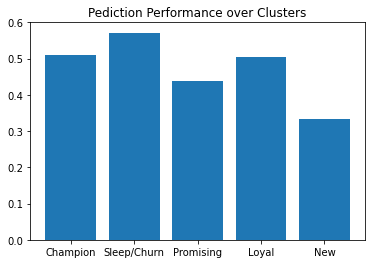

In [195]:
# access performance 
model = tf.keras.models.load_model('DNN_model.h5')
data_target = np.vstack((y_valid,y_test))
# (test_cate.reshape(-1,1),test_num)
pred = model.predict(np.vstack((X_valid,X_test)))
error_abs = np.abs(data_target-pred)/data_target
valid_ind = valid_index.tolist()
inx = valid_ind +(test_index.tolist())
error_abs=pd.Series(error_abs.reshape(-1),index=inx)


cluster_df = pd.read_csv('clustering_dataframe.csv')
cluster_df.head()
cluster_df = cluster_df[['CustomerID','Cluster']]
ndf = pd.merge(df_ft,cluster_df,how = 'left',left_on=df_ft.columns[0],right_on=cluster_df.columns[0])

q=0.5
error_value = np.quantile(error_abs,q)
ind = error_abs[error_abs<error_value].index
customer = df_ft.loc[ind,'customer_id']
target_customer = df_ft.loc[inx,'customer_id']
error_cluster = ndf.loc[ndf.customer_id.isin(customer),'Cluster']
target_cluster = ndf.loc[ndf.customer_id.isin(target_customer),'Cluster']
cluster_seg = error_cluster.value_counts()/target_cluster.value_counts()


# plot a bar chart 
cluster_list = ['Champion','Sleep/Churn','Promising','Loyal','New']
import matplotlib.pyplot as plt
plt.figure()
plt.bar(cluster_seg.index, cluster_seg.values)
plt.title('Pediction Performance over Clusters')
plt.xticks(ticks=cluster_seg.index,labels=cluster_list)
plt.show()


Error is accessed by percentage of absolute error for each cusotmers. For customers whose error lower then median value of errors, the model has best performance for customers who are about to sleep or churn, but overall, performance is quite balanced.

# How these features impact on the prediction of CLV



In [200]:
import shap

### Feature importance on test dataset

In [203]:
shap.initjs()

explainer = shap.KernelExplainer(model,X_train[:500])
shap_values = explainer.shap_values(X_test)
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [205]:
feature_importance = pd.DataFrame(np.mean(np.abs(shap_values[0]),axis=0),index=features,columns=['importance_value'])
feature_importance.importance_value.sort_values(ascending=False)

monetary_DNN        2508.801913
has_returned         432.631581
recency              334.952066
frequency_DNN        307.020447
avg_basket_value     247.211950
t                    217.805764
avg_basket_size      167.572205
time_between         115.515777
cnt_returns           84.406486
Name: importance_value, dtype: float64

monetary_DNN        2508.801913
has_returned         432.631581
recency              334.952066
frequency_DNN        307.020447
avg_basket_value     247.211950
t                    217.805764
avg_basket_size      167.572205
time_between         115.515777
cnt_returns           84.406486
Name: importance_value, dtype: float64

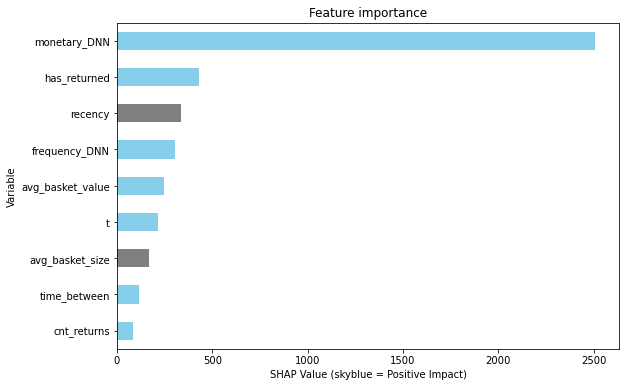

In [221]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'skyblue','grey')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(9,6),legend=False)
    ax.set_xlabel("SHAP Value (skyblue = Positive Impact)")
    ax.set_title('Feature importance')

df_test = pd.DataFrame(X_test,columns=features)
ABS_SHAP(shap_values[0],df_test)

feature_importance = pd.DataFrame(np.mean(np.abs(shap_values[0]),axis=0),index=features,columns=['importance_value'])
feature_importance.importance_value.sort_values(ascending=False)

Monetary value of feature period, as the most important feature, has significant power in prediction. Recency and 'avg_basket_value' have negative effect on CLV. This means low value of recency is related with higher value of CLV, which makes sense. It is also possible that lower 'avg_basket_value' is related to higher CLV, because someone who has bought a lot items in a time period will be unlikely to buy much in a futrue period time? Well, depends on the length of time period.

In [207]:
# inverse_transform the scaled value for interpretation 

test = scaler.inverse_transform(X_test)

# acesse feature importance at individual level 
shap.force_plot(explainer.expected_value, shap_values[0][1,:] ,test[1,:],feature_names=features)

In [215]:
shap.force_plot(explainer.expected_value, shap_values[0][1,:] ,X_test[1,:],feature_names=features)

### Feature importance for different clusters 
( Here 'New' customers should have number of orders more than 1)

In [225]:
# mapping customers with clusters
shap_customers = ndf.loc[ndf.customer_id.isin(target_customer),]

In [228]:
cluster_list = {0:'Champion',1:'Sleep/Churn',2:'Promising',3:'Loyal',4:'New'}

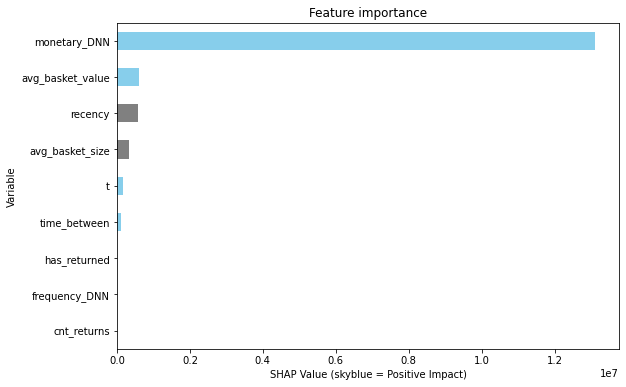

In [232]:
def feature_importance(cluster):
    
    cluster_cus = shap_customers[shap_customers.Cluster == cluster]
    X=cluster_cus[features]
    shap_values = explainer.shap_values(X)
    ABS_SHAP(shap_values[0],X)
    
    feature_importance = pd.DataFrame(np.mean(np.abs(shap_values[0]),axis=0),index=features,columns=['importance_value'])
    sorted_importance = feature_importance.importance_value.sort_values(ascending=False)
    
    return sorted_importance

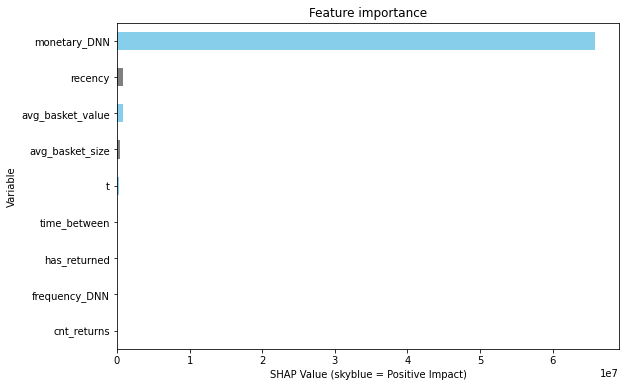

In [234]:
# 'Champion'
feature_importance(0)

invalid value encountered in true_divide
invalid value encountered in true_divide


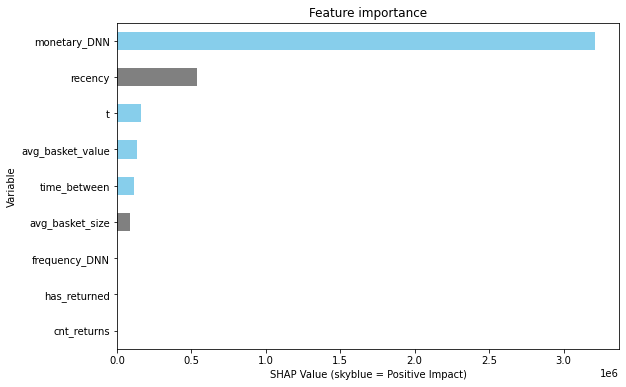

In [235]:
# 'Sleep/Churn'
feature_importance(1)

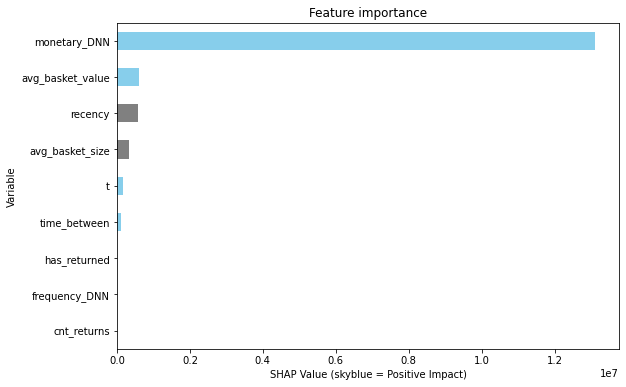

In [236]:
#'Promising'
feature_importance(2)

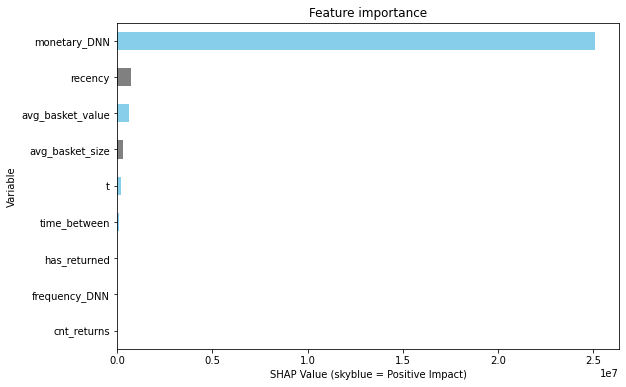

In [237]:
#'Loyal'
feature_importance(3)

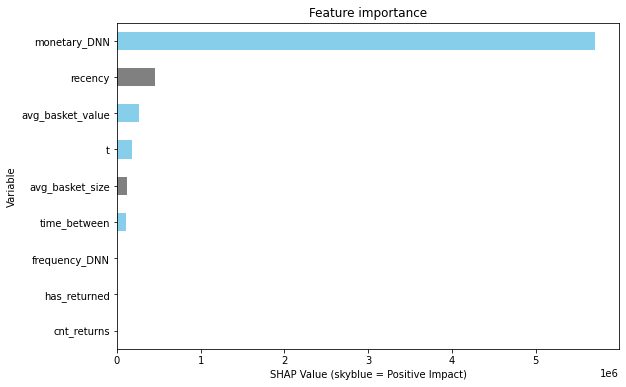

In [238]:
#'New'
feature_importance(4)

For all culsters, monetary value of feature period is the dominant feature in prediction of CLV. Recency and average basket size are consistently have negative effect on CLV. Recency have relatively higher shap value for 'New'd customer and 'Sleep/Churn' customer than other type of customers, which makes sense, becuse recency is one of the most important feature for distinguishing new customers and sleeping customers with other type of customers.